In [347]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import timeit

In [348]:
def getCrossProduct(p0,p1,p2):
    # Returns which is more counterclockwise
    cross_product = (p1[0] - p0[0]) * (p2[1]-p0[1]) - (p2[0]-p0[0]) * (p1[1]-p0[1])

    if cross_product == 0:
        return 0 #p1
    elif cross_product > 0:
        return 1 #p2
    else:
        return -1 #p1

In [349]:
def findFurthest(origin, points):
    def distance(point):
        return math.sqrt((origin[0] - point[0]) ** 2 + (origin[1] - point[1]) ** 2)
    
    return max(points, key=distance, default=None)

In [350]:
def jarvis(inputSet):
    outputSet = []
    if len(inputSet) < 3: # Since anything less than these number of points can't create a convex hull
        return inputSet

    # Find the leftmost point
    firstPoint = min(inputSet)
    curPoint = firstPoint
    nextPoint = None
    while nextPoint != firstPoint:
        outputSet.append(curPoint)

        nextPoint = inputSet[0] if inputSet[0] != curPoint else inputSet[1]

        for testPoint in inputSet:
            if testPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)
            if crossProduct > 0:
                nextPoint = testPoint
            elif crossProduct == 0:
                nextPoint = findFurthest(curPoint, [nextPoint, testPoint])
            

        curPoint = nextPoint
    return outputSet

In [351]:
def grahamscan(inputSet):
    
    pointAnglesDict = {} # Stores points in a list according to their angles - Points with the same angle will be appended to the list
    firstPoint = min(inputSet, key=lambda p: (p[1], p[0])) # Get the lowest and leftmost point
    outputSet = [firstPoint]

    for point in inputSet:
        if point == firstPoint:
            continue
        
        angle_rad = math.atan2(point[1] - firstPoint[1], point[0] - firstPoint[0] )

        if angle_rad in pointAnglesDict:
            pointAnglesDict[angle_rad].append(point)
        else:
            pointAnglesDict[angle_rad] = [point]

    sortedPointAngles = sorted(list(pointAnglesDict.items()))

    point = None
    for pointDict in sortedPointAngles:
        if len(pointDict[1]) > 1:
            point = findFurthest(firstPoint, pointDict[1])
        else:
            point = pointDict[1][0]


        while len(outputSet) >= 2 and getCrossProduct(outputSet[-2], outputSet[-1], point) <= 0:
            outputSet.pop()  # Remove the last point in the outputSet because it makes a non-left turn
        outputSet.append(point)

    return outputSet

In [352]:
def linearSearch(subHull, curPoint):
    hullSize = len(subHull)
    if hullSize == 1:
        return subHull[0]
    elif hullSize == 2:
        crossProduct = getCrossProduct(curPoint, subHull[0], subHull[1])
        if crossProduct > 0:
            return subHull[0]
        elif crossProduct < 0:
            return subHull[1]
        else:
            if curPoint == subHull[0]:
                return subHull[1]
            elif curPoint == subHull[1]:
                return subHull[0]
            return findFurthest(curPoint, [subHull[0], subHull[1]])

    pointer = 0
    nextPointer = (pointer + 1) % hullSize

    while getCrossProduct(curPoint, subHull[pointer], subHull[nextPointer]) <= 0:
        pointer = nextPointer
        nextPointer = (pointer + 1) % hullSize

    return subHull[pointer]


In [353]:
def linearChan(inputSet, groupSize):
  outputSet = []
  
  subPoints = [inputSet[i:i + groupSize] for i in range(0, len(inputSet), groupSize)]
  subHulls = [grahamscan(points) for points in subPoints]
  allSubHullPoints = [point for subHull in subHulls for point in subHull]

  outputSet = jarvis(allSubHullPoints)

  return outputSet


In [354]:
def binarySearchBitwise(subHull, curPoint):

    # print(subHull, curPoint)
    hullSize = len(subHull)

    if hullSize == 1:
        return subHull[0]
    elif hullSize == 2:
        crossProduct = getCrossProduct(curPoint, subHull[0], subHull[1])
        if crossProduct > 0:
            return subHull[0]
        elif crossProduct < 0:
            return subHull[1]
        else:
            if curPoint == subHull[0]:
                return subHull[1]
            elif curPoint == subHull[1]:
                return subHull[0]
            return findFurthest(curPoint, [subHull[0], subHull[1]])

    pointer = 0
    stepSize = max(hullSize >> 1, 1)
    rightPointer = 0

    # print(hullSize)
    

    while True:
        # Need to think about what if the curPoint is the same as subHull[pointer]
        pointerChanged = False
        stepSize = max(stepSize >> 1, 1)

        for operation in [+1, -1]:
            nextPointer = (pointer + operation) % hullSize

            cp = getCrossProduct(curPoint, subHull[pointer], subHull[nextPointer])
            if cp < 0:
                pointer = (pointer + (stepSize * operation)) % hullSize
                pointerChanged = True
                break
            elif cp == 0:
                if curPoint == subHull[nextPointer]:
                    oppositePointer = (nextPointer + (operation)) % hullSize
                    cp = getCrossProduct(curPoint, subHull[pointer], subHull[oppositePointer])
                    if cp < 0:
                        return subHull[oppositePointer]
                    else:
                        return subHull[pointer]
                else:
                    nextNextPointer = (nextPointer + operation) % hullSize
                    if (getCrossProduct(curPoint, subHull[nextPointer], subHull[nextNextPointer])> 0):
                        return findFurthest(curPoint, [subHull[pointer], subHull[nextPointer]])

        if not pointerChanged:
            return subHull[pointer]


In [355]:
def binarySearchDivision(subHull, curPoint):

    # print(subHull, curPoint)
    hullSize = len(subHull)

    if hullSize == 1:
        return subHull[0]
    elif hullSize == 2:
        crossProduct = getCrossProduct(curPoint, subHull[0], subHull[1])
        if crossProduct > 0:
            return subHull[0]
        elif crossProduct < 0:
            return subHull[1]
        else:
            if curPoint == subHull[0]:
                return subHull[1]
            elif curPoint == subHull[1]:
                return subHull[0]
            return findFurthest(curPoint, [subHull[0], subHull[1]])

    pointer = 0
    stepSize = max(hullSize // 2, 1)
    rightPointer = 0

    # print(hullSize)
    

    while True:
        # Need to think about what if the curPoint is the same as subHull[pointer]
        pointerChanged = False
        stepSize = max(stepSize // 2, 1)

        for operation in [+1, -1]:
            nextPointer = (pointer + operation) % hullSize

            cp = getCrossProduct(curPoint, subHull[pointer], subHull[nextPointer])
            if cp < 0:
                pointer = (pointer + (stepSize * operation)) % hullSize
                pointerChanged = True
                break
            elif cp == 0:
                if curPoint == subHull[nextPointer]:
                    oppositePointer = (nextPointer + (operation)) % hullSize
                    cp = getCrossProduct(curPoint, subHull[pointer], subHull[oppositePointer])
                    if cp < 0:
                        return subHull[oppositePointer]
                    else:
                        return subHull[pointer]
                else:
                    nextNextPointer = (nextPointer + operation) % hullSize
                    if (getCrossProduct(curPoint, subHull[nextPointer], subHull[nextNextPointer])> 0):
                        return findFurthest(curPoint, [subHull[pointer], subHull[nextPointer]])

        if not pointerChanged:
            return subHull[pointer]


In [356]:
def binaryChanBitwise(inputSet, groupSize=-1):
    hullSize = len(inputSet)

    if groupSize == -1:
        groupSize = math.ceil(math.sqrt(hullSize))

    subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
    outputSet = []
    subHulls = [grahamscan(subset) for subset in subsets]

    firstPoint = min(inputSet, key=lambda p: (p[1], p[0]))
    curPoint = firstPoint
    nextPoint = None
    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        rightPoints = [binarySearchBitwise(subHull, curPoint) for subHull in subHulls]
        nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

        for rightPoint in rightPoints:
            if rightPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
            if crossProduct < 0:
                nextPoint = rightPoint
            elif crossProduct == 0:
                nextPoint = findFurthest(curPoint, [nextPoint, rightPoint])

        curPoint = nextPoint
    return outputSet


In [357]:
def binaryChanDivision(inputSet, groupSize=-1):
    hullSize = len(inputSet)

    if groupSize == -1:
        groupSize = math.ceil(math.sqrt(hullSize))

    subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
    outputSet = []
    subHulls = [grahamscan(subset) for subset in subsets]

    firstPoint = min(inputSet, key=lambda p: (p[1], p[0]))
    curPoint = firstPoint
    nextPoint = None
    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        rightPoints = [binarySearchDivision(subHull, curPoint) for subHull in subHulls]
        nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

        for rightPoint in rightPoints:
            if rightPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
            if crossProduct < 0:
                nextPoint = rightPoint
            elif crossProduct == 0:
                nextPoint = findFurthest(curPoint, [nextPoint, rightPoint])

        curPoint = nextPoint
    return outputSet


In [358]:
def getGroupSize(inputSize):


    if inputSize >= 100000:
        return 2000
    elif inputSize >= 10000:
        return math.ceil(0.13 * inputSize + 728)
    elif inputSize >= 500:
        return math.ceil(inputSize / 3)
    elif inputSize >= 100:
        return math.ceil(inputSize / 2)
    else:
        return math.ceil(inputSize / 3)
        

In [359]:
class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    1. List of tuples - Store the (x,y) coordinate points of each point
    [to be defined as part of the coursework]
    2. Size - Number of points that this object should have

    Methods
    -------
    generatePoints(size)
    * size will be how many points are wanted to be created
    [to be defined as part of the coursework]

    """
       
    def __init__(self):
        self.points = []


    def getPoints(self):
        return self.points

    def generatePoints(self, size):
        self.points = []
        while len(self.points) < size:
            xp = random.randint(0,32767)
            yp = random.randint(0,32767)
            if (xp,yp) not in self.points:
                self.points.append((xp,yp))
        return self.points

    def genHorizontalLine(self,size):
        self.points = []
        while len(self.points) < size:
            xp = random.randint(0,32767)
            if (xp,0) not in self.points:
                self.points.append((xp,0))
        return self.points
    

    def generatePointsOnConvexHull(self, num_points, center=(16383, 16383), radius=16000):
        """ Generate points evenly spaced along the circumference of a circle.
        Parameters: num_points (int): Number of points to generate.
        center (tuple): Coordinates of the center of the circle.
        Default is (0, 0). 
        radius (float): Radius of the circle. 
        Default is 100. 
        Returns: list: List of (x, y) coordinates representing the points. """ 
        self.points = []
        for i in range(num_points):
            angle = 2 * math.pi * i / num_points 
            x = int(center[0] + radius * math.cos(angle) )
            y = int(center[1] + radius * math.sin(angle) )
            self.points.append((x, y))

        random.shuffle(self.points)
        return self.points


    def generateDenseCluster(self, size):
        center = 16383
        mu = 0 #8150
        sigma = 5600 #5461
        self.points = []
       
        while len(self.points) < size:
            theta = random.uniform(0, 2 * math.pi)
            
            # Generate a magnitude r with normal distribution
            r = random.normalvariate(mu, sigma)
            x = math.ceil(r * math.cos(theta) + center)
            y = math.ceil(r * math.sin(theta) + center)
            # Convert polar to Cartesian coordinates
            x = max(min(x, 32767), 0)
            y = max(min(y, 32767), 0)
            
            self.points.append((x, y))



        return self.points

    

In [360]:
import timeit
import matplotlib.pyplot as plt

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__(self):
        self.testGen = TestDataGenerator()
        self.jarvisBorder = []
        self.grahamBorder = []
        self.linearChanBorder = []
        self.binaryChanBitwiseBorder = []
        self.binaryChanDivisionBorder = []
        

    def runJarvis(self, points):
        start = timeit.default_timer()
        self.jarvisBorder = jarvis(points)
        end = timeit.default_timer()
        return (end - start)#, len(self.jarvisBorder)
    
    def runGraham(self, points):
        start = timeit.default_timer()
        self.grahamBorder = grahamscan(points)
        end = timeit.default_timer()
        return (end - start)#, len(self.grahamBorder)
    
    def runBinaryChanBitwise(self, points, groupSize=-1):
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.binaryChanBitwiseBorder = binaryChanBitwise(points, groupSize)
        end = timeit.default_timer()
        return (end - start)#, len(self.chenBorder)
    
    def runBinaryChanDivision(self, points, groupSize=-1):
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.binaryChanDivisionBorder = binaryChanDivision(points, groupSize)
        end = timeit.default_timer()
        return (end - start)#, len(self.chenBorder)
    
    def runLinearChan(self, points, groupSize=-1):
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.linearChanBorder = linearChan(points, groupSize)
        end = timeit.default_timer()
        return (end - start)#, len(self.chenBorder)

    def algoTest(self, repeats, sizes):
        wrongCount = 0
        wrongTests = []

        jarvisTime = 0
        grahamTime = 0
        linearChanTime = 0
        binaryChanTime = 0

        times = [[] for _ in range(4)]

        for size in sizes:
            print("\nCurrent Size:",size)
            for _ in range(repeats):
                
                self.testGen.generatePoints(size)
                
                self.runJarvis(self.testGen.points)
                self.runGraham(self.testGen.points)
                self.runLinearChan(self.testGen.points)
                self.runBinaryChanBitwise(self.testGen.points)
                self.runBinaryChanDivision(self.testGen.points)

                self.jarvisBorder.sort()
                self.grahamBorder.sort()
                self.linearChanBorder.sort()
                self.binaryChanBitwiseBorder.sort()
                self.binaryChanDivisionBorder.sort()

                if not (self.jarvisBorder == self.grahamBorder == self.linearChanBorder == self.binaryChanBorder):
                    wrongTests.append(self.testGen.points)
                    wrongCount += 1

            print("Wrong So Far:", wrongCount)
            

        return wrongCount, wrongTests
    
    def compareAlgos(self, repeats, sizes, testType):
        # Test Type - 0 : Random, 1 : Dense Cluster, 2 : All points on hull
        titles =["Random", "Dense Cluster"]
        jarvisTime = 0
        grahamTime = 0
        linearChanTime = 0
        binaryChanTime = 0
        jarvisTimes = []
        grahamTimes = []
        linearChanTimes = []
        binaryChanBitwiseTimes = []
        binaryChanDivisionTimes = []

        times = [[] for _ in range(5)]

        for size in sizes:
            jarvisTimes = []
            grahamTimes = []
            linearChanTimes = []
            binaryChanBitwiseTimes = []
            binaryChanDivisionTimes = []
            for _ in range(repeats):
                if testType == 0:
                    self.testGen.generatePoints(size)
                elif testType == 1:
                    self.testGen.generateDenseCluster(size)

                # jarvisTime = self.runJarvis(self.testGen.points)
                # grahamTime = self.runGraham(self.testGen.points)
                # linearChanTime = self.runLinearChan(self.testGen.points)
                # binaryChanTime = self.runBinaryChan(self.testGen.points)

                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                linearChanTimes.append(self.runLinearChan(self.testGen.points))
                binaryChanBitwiseTimes.append(self.runBinaryChanBitwise(self.testGen.points))
                binaryChanDivisionTimes.append(self.runBinaryChanDivision(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(linearChanTimes)[repeats//2])
            times[3].append(sorted(binaryChanBitwiseTimes)[repeats//2])
            times[4].append(sorted(binaryChanDivisionTimes)[repeats//2])

            # times[0].append(jarvisTime / repeats)
            # times[1].append(grahamTime / repeats)
            # times[2].append(linearChanTime / repeats)
            # times[3].append(binaryChanTime / repeats)

        self.plotResults("Input Size", sizes, ["Jarvis", "Graham", "Chan (Linear)", "Chan (Binary, Bitwise)", "Chan (Binary, Division)"], "Time Taken", times, "Comparing Algorithms : " + titles[testType])

    def comapreAlgosAllOnHull(self, repeats, sizes):
        # Test Type - 0 : Random, 1 : Dense Cluster, 2 : All points on hull

        jarvisTime = 0
        grahamTime = 0
        linearChanTime = 0
        binaryChanTime = 0

        jarvisTimes = []
        grahamTimes = []
        linearChanTimes = []
        binaryChanTimes = []

        times = [[] for _ in range(4)]
        actualSizes = []
        for size in sizes:
            jarvisTimes = []
            grahamTimes = []
            linearChanTimes = []
            binaryChanTimes = []
            self.testGen.generatePointsOnConvexHull(size) # Might need to do separate functino since the size not always = h
            actualSizes.append(len(grahamscan(self.testGen.points)))
            for _ in range(repeats):
                
                
                # jarvisTime = self.runJarvis(self.testGen.points)
                # grahamTime = self.runGraham(self.testGen.points)
                # linearChanTime = self.runLinearChan(self.testGen.points)
                # binaryChanTime = self.runBinaryChan(self.testGen.points)

                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                linearChanTimes.append(self.runLinearChan(self.testGen.points))
                binaryChanTimes.append(self.runBinaryChan(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(linearChanTimes)[repeats//2])
            times[3].append(sorted(binaryChanTimes)[repeats//2])
            # times[0].append(jarvisTime / repeats)
            # times[1].append(grahamTime / repeats)
            # times[2].append(linearChanTime / repeats)
            # times[3].append(binaryChanTime / repeats)
        print(actualSizes)
        print(times)

        self.plotResults("Input Size", actualSizes, ["Jarvis", "Graham", "Chan (Linear)", "Chan (Binary)"], "Time Taken", times, "Comparing Algorithms : All Points on Hull")
    
    def compareChanLinearToBinary(self, inputSizes):
        linear_results = []
        binary_results = []

        for i, inputSize in enumerate(inputSizes):
            hullPoints = self.testGen.generatePoints(inputSize)


            linear_results.append(self.runLinearChan(hullPoints))

            binary_results.append(self.runBinaryChan(hullPoints))

        self.plotResults("Input Size", inputSizes, ["Linear", "Binary"], "Time Taken", [linear_results, binary_results], "Chan : Linear vs Binary")

    def findingBinaryChanOptimalGroupSize(self, inputSize, repeats, groupSizes):
        results = []

        self.testGen.generatePoints(inputSize)
        for groupSize in groupSizes:
            time = []
            for i in range(repeats):
                
                time.append(self.runBinaryChan(self.testGen.points, groupSize))
            results.append(sorted(time)[math.ceil(repeats/2)])

        self.plotResults("Group Size", groupSizes, ["Data"], "Time Taken (s)", [results], "Finding Optimal Group Size for : " + str(inputSize)) #

    def drawHull(self, points, lines):
        margin = 5000
        xPoints, yPoints = zip(*points)
        tempLines = lines + [lines[0]]
        xLine, yLine = zip(*tempLines)
        plt.scatter(xPoints, yPoints, color='red', s=3)
        plt.plot(xLine, yLine, '-', color='blue')

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    def plotPoints(self, points):
        margin = 5000
        xPoints, yPoints = zip(*points)
        plt.scatter(xPoints, yPoints, color='red', s=1)

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    def plotResults(self, xTitle, xValues, legendLabels, yTitle, yValueList, title=""):
        plt.figure(figsize=(8,6))

        for i, yValues in enumerate(yValueList):
            plt.plot(xValues, yValues, 'o-', label=legendLabels[i])
        plt.title(title)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.grid(True)

        plt.legend()

        plt.tight_layout()
        plt.show()

In [361]:
test = ExperimentalFramework()
gen = TestDataGenerator()



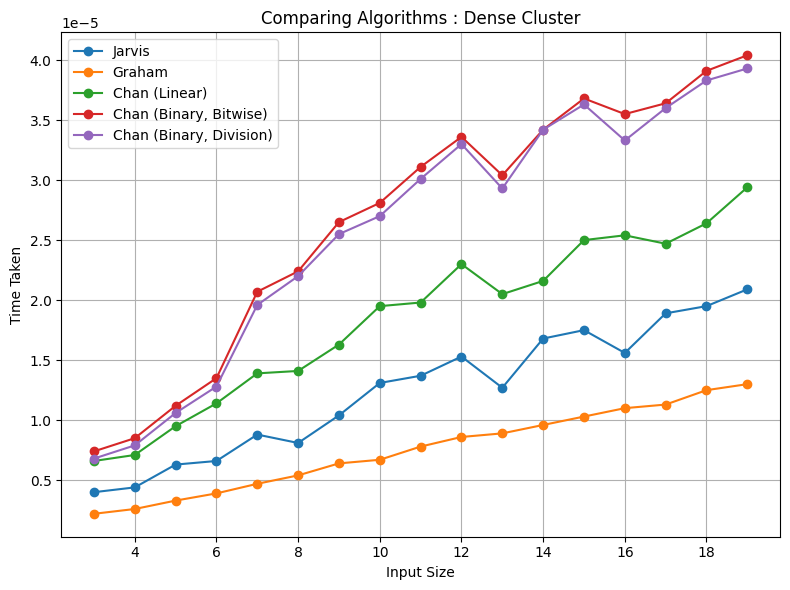

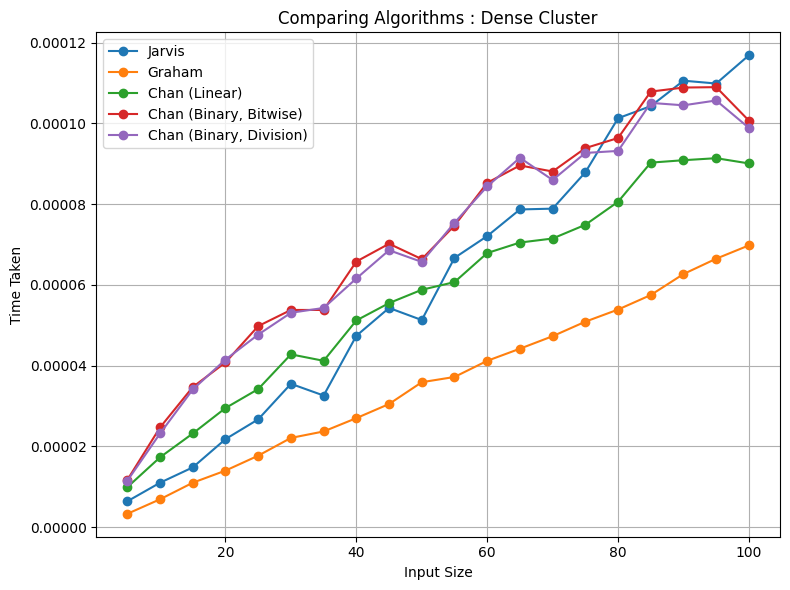

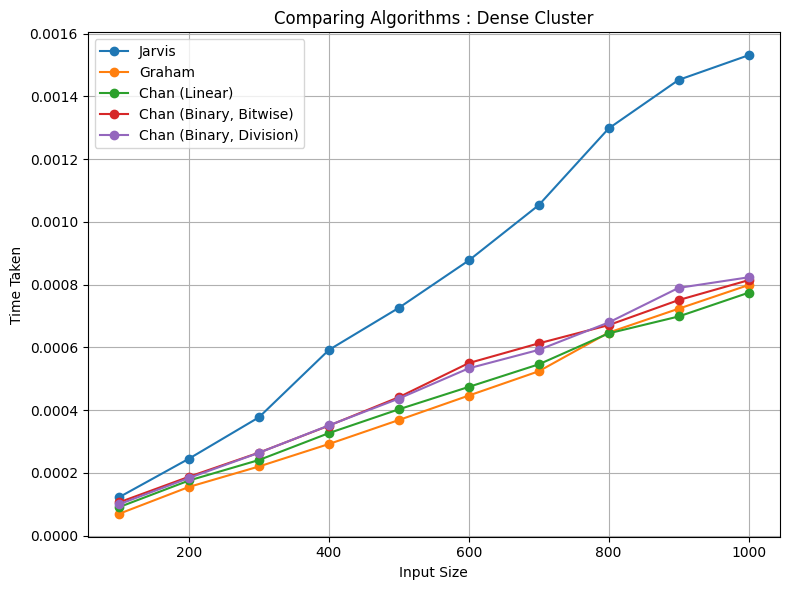

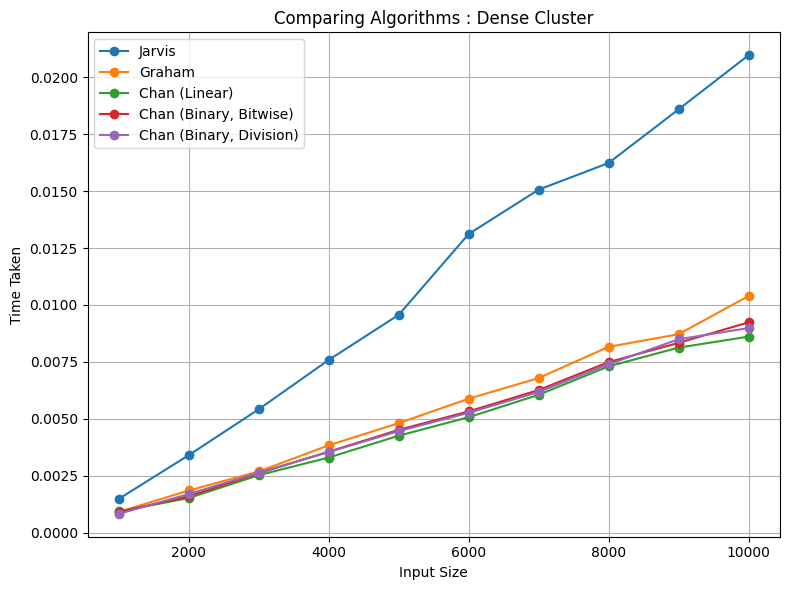

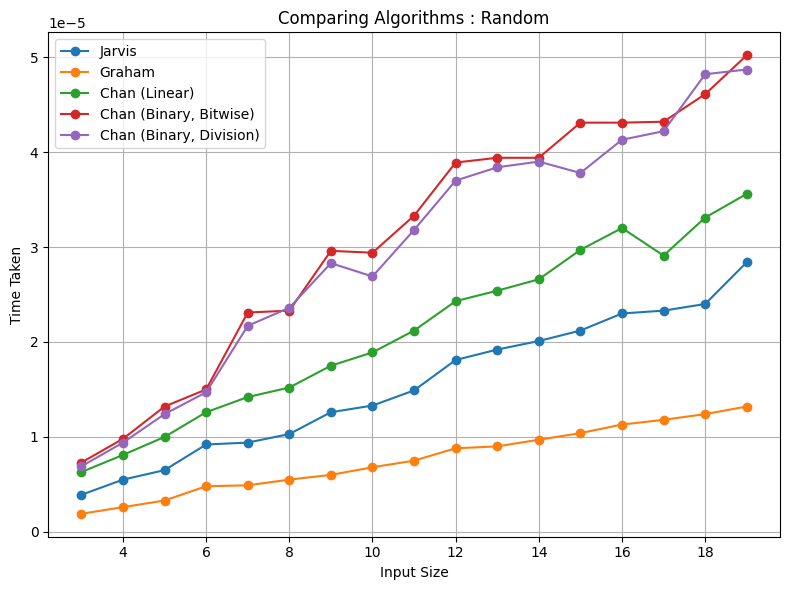

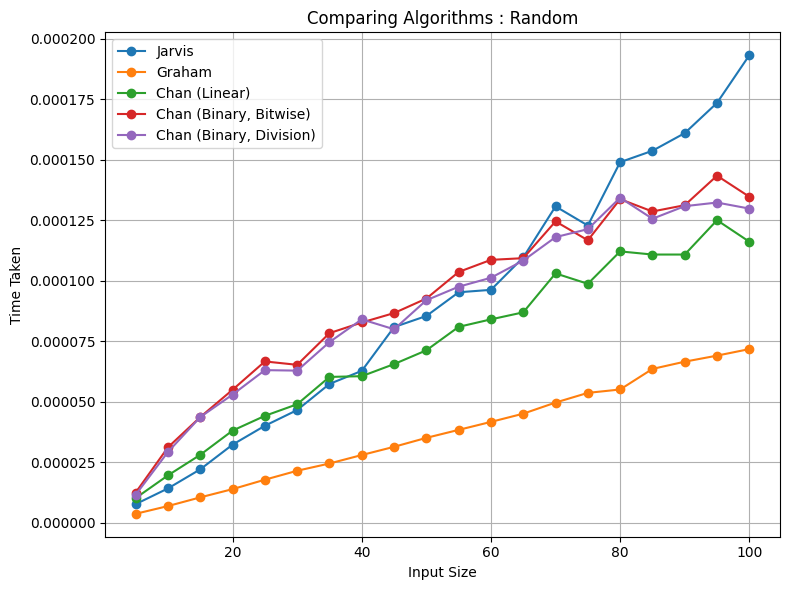

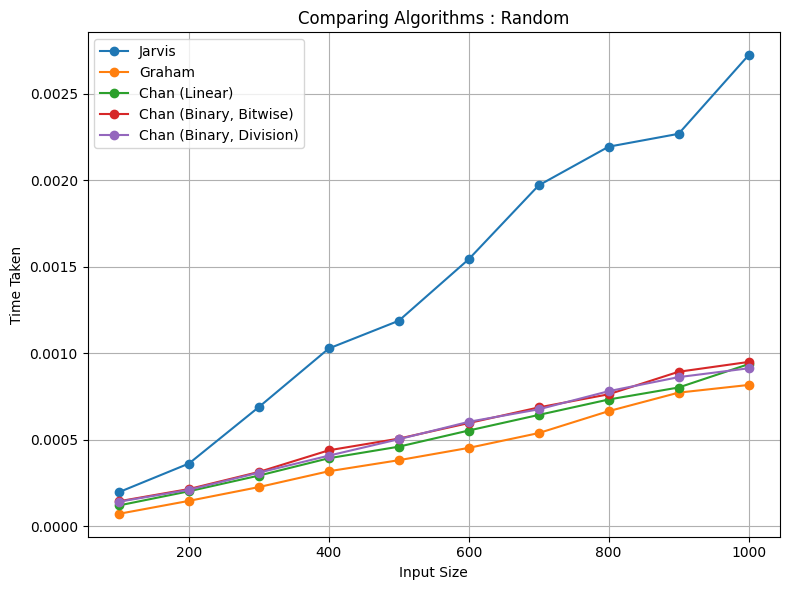

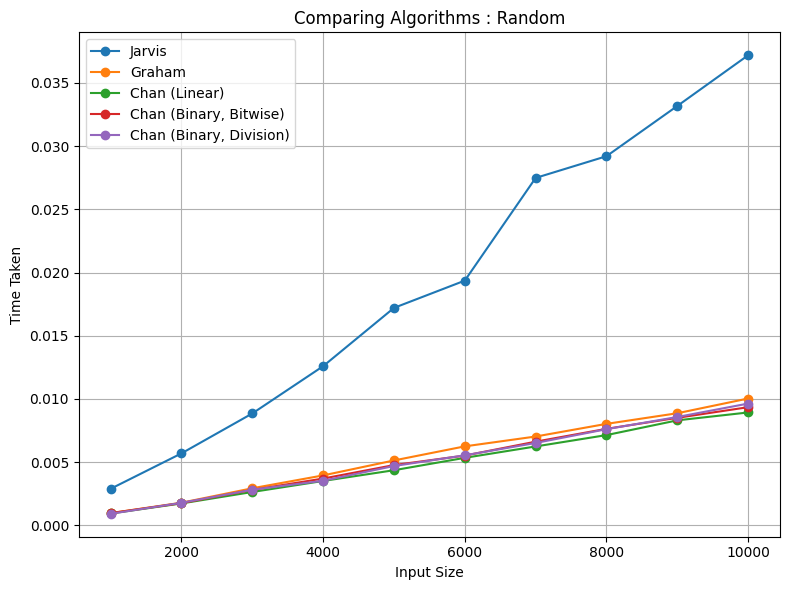

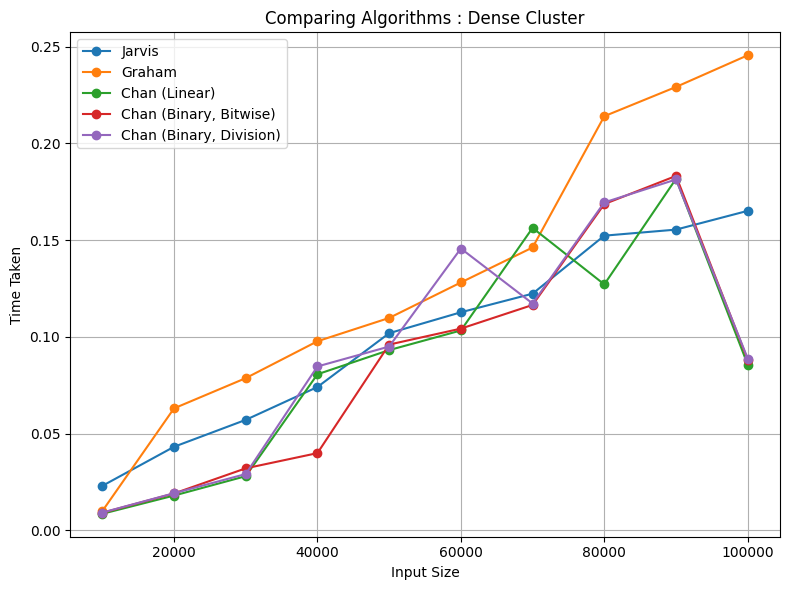

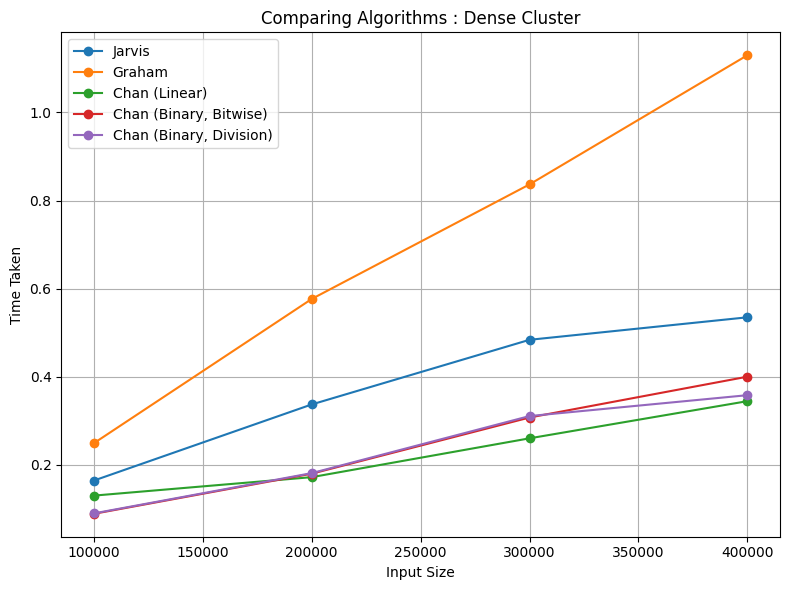

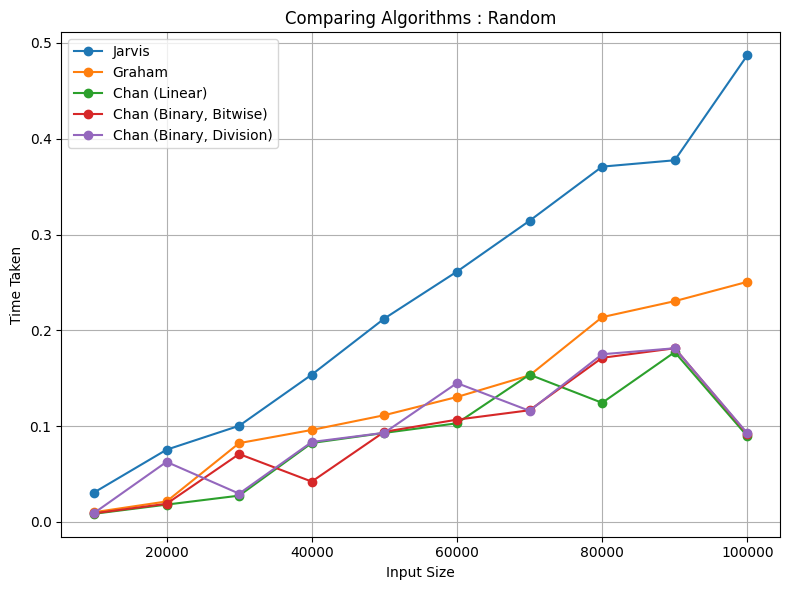

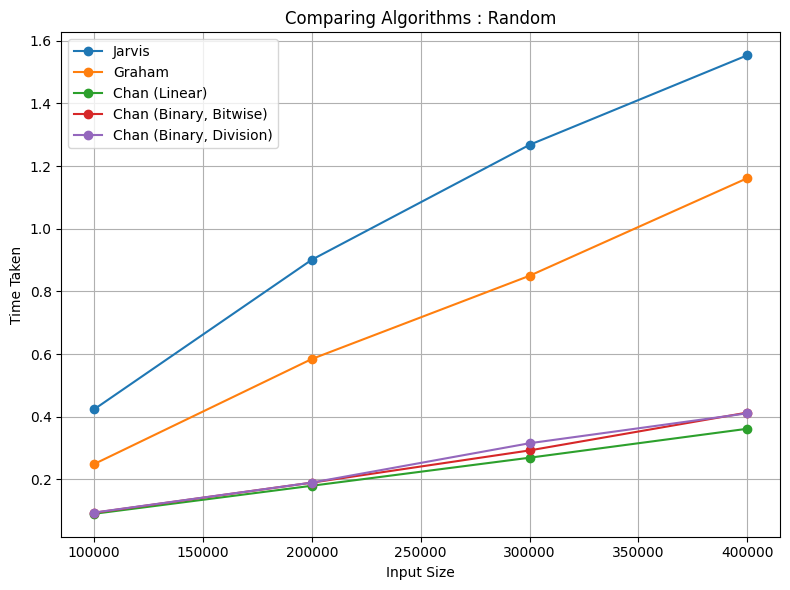

In [362]:
# test.compareChanLinearToBinary([i for i in range(10000, 100000, 10000)])


test.compareAlgos(10, [i for i in range(3, 20, 1)], 1)
test.compareAlgos(10, [i for i in range(5, 105, 5)], 1)
test.compareAlgos(10, [i for i in range(100, 1100, 100)], 1)
test.compareAlgos(10, [i for i in range(1000, 11000, 1000)], 1)


test.compareAlgos(10, [i for i in range(3, 20, 1)], 0)
test.compareAlgos(10, [i for i in range(5, 105, 5)], 0)
test.compareAlgos(10, [i for i in range(100, 1100, 100)], 0)
test.compareAlgos(10, [i for i in range(1000, 11000, 1000)], 0)

test.compareAlgos(10, [i for i in range(10000, 110000, 10000)], 1)
test.compareAlgos(10, [i for i in range(100000, 500000, 100000)], 1)

test.compareAlgos(10, [i for i in range(10000, 110000, 10000)], 0)
test.compareAlgos(10, [i for i in range(100000, 500000, 100000)], 0)

# test.findingBinaryChanOptimalGroupSize(150000, 5, [i for i in range(1600,2100,50)])

# for size in [i for i in range(200000, 550000, 50000)]:
#     for _ in range(5):
#         test.findingBinaryChanOptimalGroupSize(size, 5, [i for i in range(1600,2500,50)])



